In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
import re


import scanpy as sc

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata = sc.read_h5ad("e00ab1f4-28cd-497d-b889-94d45840f423.h5ad")
adata

AnnData object with n_obs × n_vars = 225487 × 25484
    obs: 'sample_id', 'publication', 'sample_name', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch', 'derive', 'time', 'protocol', 'molecular', 'gel', 'level_1', 'level_2', 'level_3', 'leiden_res5_l2', 'leiden_res5_l3', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_umap'

In [3]:
def get_he_data(adata):
    metadata = pd.read_csv("He_Annotated_OE_Organoid_obs.csv", encoding='utf-8', low_memory=False)
    # first column was without header 
    metadata.rename(columns={'Unnamed: 0': 'clear_name'}, inplace=True)
    metadata['clear_name'] = metadata['clear_name'].str.split('-').str[0]
    
    #  barcode can be found as clear_name 
    batch2batch = {"He_Cell_2022_deltaNp63alpha_overexpression" : "WSSS_F_LNG10282021",
                   "He_Cell_2022_ASCL1_overexpression"          : "WSSS_F_LNG10282022",
                   "He_Cell_2022_NEUROD1_overexpression"        : "WSSS_F_LNG10282023"}               
    
    for batch in batch2batch: 
        mapped_batch = batch2batch[batch]
        
        sub_obs1 = adata[adata.obs.sample_id == batch].obs.copy()
        sub_obs1['clear_name'] = sub_obs1.index.str.split('-').str[0]
        sub_meta1 = metadata[metadata['batch'] == mapped_batch].copy()
    
        merged_obs = pd.merge(sub_obs1.reset_index(), sub_meta1, on='clear_name', how = 'left' )
        
        #print(len(merged_obs))
    
        adata.obs.loc[adata.obs.sample_id == batch, 'new_annotation'] = merged_obs.new_celltype.tolist() 
    
        
    

In [4]:
def get_chan_data(adata):
    metadata = pd.read_csv("chan_metadata_scRNAseq.csv", encoding='utf-8', low_memory=False)
    metadata.rename(columns={'Unnamed: 0': 'clear_name'}, inplace=True)
    
    # barcode can be found as clear_name 
    metadata['clear_name'] = metadata['clear_name'].str.split('-').str[0]
    metadata['clear_name'] = metadata['clear_name'].str.split('_').str[1]
    
    batch2batch = {"Chan_NatCommun_2022_nasopharyngeal_organoids" :  "SCNPO1",
                   "Chan_NatCommun_2022_bronchial_organoids"      :  "SCBO",} 
    
    for batch in batch2batch:      
        mapped_batch = batch2batch[batch] 
                       
        sub_obs = adata[adata.obs.sample_id == batch].obs.copy() 
        sub_obs['clear_name'] = sub_obs.index.str.split('-').str[0]
        sub_meta = metadata[metadata['orig.ident'] == mapped_batch]
        
        merged_obs = pd.merge(sub_obs.reset_index(), sub_meta, on='clear_name', how = 'left') 
        
        adata.obs.loc[adata.obs.sample_id == batch, 'new_annotation'] = merged_obs.annotation.tolist()


# check barcode intersection 
# common_names = metadata[metadata['clear_name'].isin(sub_obs['clear_name'])]


In [5]:
def get_miller_data(adata):
    metadata = pd.read_csv("Miller_d21_cl_with_cell_types.csv")
    
    # barcode can be found as clear_name 
    metadata['clear_name'] = metadata['CellID'].str.split('_').str[1]
    
    sub_obs = adata[adata.obs.sample_id == 'Miller_DevCell_2020_Day_21'].obs.copy()
    sub_obs['clear_name'] = sub_obs.index.str.split('-').str[0]
    
    merged_obs = pd.merge(sub_obs.reset_index(), metadata, on='clear_name', how = 'left')
    
    adata.obs.loc[adata.obs.sample_id == 'Miller_DevCell_2020_Day_21', 'new_annotation'] = merged_obs.CellType.tolist()

In [6]:
def get_lim_data(adata):
    metadata = pd.read_csv("Lim_obs_211014KTOrganoid.csv")
    metadata.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
    
    metadata['clear_name'] = metadata['ID'].str.split('-').str[0]

    sample2batch = {"Lim_CellStemCell_2023_Lung_organoid_epithelium" : "WSSS_F_LNG10293351+WSSS_F_LNG10831895", 
                   "Lim_CellStemCell_2023_Lung_alveolar_organoid_epithelium" : "WSSS_F_LNG10293352+WSSS_F_LNG10831896"}

    for sample in sample2batch: 
        mapped_batch = sample2batch[sample]
                    
        sub_obs = adata[adata.obs.sample_id == sample].obs.copy()
        sub_obs['clear_name'] = sub_obs.index.str.split('-').str[0]
        
        sub_meta = metadata[metadata['batch'] == mapped_batch]
        
        merged_obs = pd.merge(sub_obs.reset_index(), sub_meta, on = 'clear_name', how = 'left') 
        adata.obs.loc[adata.obs.sample_id == sample, 'new_annotation'] = merged_obs.celltype.tolist() 

In [7]:
def get_hof_data(adata):
    metadata = sc.read_h5ad("Hoffmann_GSE197949_organoids_all.h5ad")
    metadata.obs['clear_name'] = metadata.obs.index.str.split('_').str[1]
    metadata.obs['clear_name'] = metadata.obs['clear_name'].str.split('-').str[0]
    
    sample2sample = { "Hoffmann_CommunBiol_2022_AO15_HT2_16h_control" : "AO15-HT2-16h-control",
                     "Hoffmann_CommunBiol_2022_AO15_pool_16h_control" : "AO15-pool-16h-control",
                     "Hoffmann_CommunBiol_2022_AO22_HT2_16h_control" : "AO22-HT2-16h-control",
                     "Hoffmann_CommunBiol_2022_AO16_HT2_16h_control" : "AO16-HT2-16h-control",
                     "Hoffmann_CommunBiol_2022_AO22_pool_16h_control" : "AO22-pool-16h-control",
                     "Hoffmann_CommunBiol_2022_AO16_pool_16h_control" : "AO16-pool-16h-control"}
    
    for sample in sample2sample:
        mapped_sample = sample2sample[sample]
    
        sub_obs = adata[adata.obs.sample_id == sample].obs.copy()
        sub_obs['clear_name'] = sub_obs.index.str.split('control_').str[1]
        sub_obs['clear_name'] = sub_obs['clear_name'].str.split('-').str[0]
    
        sub_meta = metadata[metadata.obs['orig.ident'] == mapped_sample]
    
        merged_obs = pd.merge(sub_obs.reset_index(), sub_meta.obs, on = 'clear_name', how = 'left') 
        adata.obs.loc[adata.obs.sample_id == sample, 'new_annotation'] = merged_obs['ident'].tolist() 
        #print(adata.obs.loc[adata.obs.sample_id == sample, 'new_annotation'])

In [8]:
def get_hein_data(adata): 

    metadata = []
    
    metadata1 = sc.read_h5ad("ConcholaHeinFig4A.h5ad")
    metadata1.obs['clear_name'] = metadata1.obs.index.str.split('-').str[0]
    
    match_1 = {"Hein_Dev_2022_10_week_iBTO"      : "5178-1",
               "Hein_Dev_2022_4_week_iBTO"       : "5178-2"}
    
    
    for sample in match_1:
        mapped_sample = match_1[sample]
        
        sub_obs = adata[adata.obs.sample_id == sample].obs.copy()
        sub_obs['clear_name'] = sub_obs.index.str.split('-').str[0]
    
        sub_meta = metadata1[metadata1.obs['orig.ident'] == mapped_sample]
    
        merged_obs = pd.merge(sub_obs.reset_index(), sub_meta.obs, on = 'clear_name', how = 'left') 
        adata.obs.loc[adata.obs.sample_id == sample, 'new_annotation'] = merged_obs['ident'].tolist() 
    
    
    
    metadata2 = sc.read_h5ad("ConcholaHeinFig2G.h5ad")
    metadata2.obs['clear_name'] = metadata2.obs.index.str.split('-').str[0]
    
    match_2 = {"Hein_Dev_2022_6_week_LPO_Batch2" : "4511-4",
                "Hein_Dev_2022_3_week_LPO_Batch2" : "4511-1",
                "Hein_Dev_2022_3_week_LPO_Batch1" : "4511-1",
                "Hein_Dev_2022_10_week_LPO"       : "4511-5",
                "Hein_Dev_2022_6_week_LPO_Batch1" : "4511-3"}
               # 4511-2 does not have a match in adata
    
    for sample in match_2:
        mapped_sample = match_2[sample]
        
        sub_obs = adata[adata.obs.sample_id == sample].obs.copy()
        sub_obs['clear_name'] = sub_obs.index.str.split('-').str[0]
    
        sub_meta = metadata2[metadata2.obs['orig.ident'] == mapped_sample]
    
        merged_obs = pd.merge(sub_obs.reset_index(), sub_meta.obs, on = 'clear_name', how = 'left') 
        adata.obs.loc[adata.obs.sample_id == sample, 'new_annotation'] = merged_obs['ident'].tolist() 
    
    
    
    metadata3 = sc.read_h5ad("ConcholaHeinFig1F.h5ad")
    metadata3.obs['clear_name'] = metadata3.obs.index.str.split('-').str[0]
    metadata3.obs
    
    match_3 = {"Hein_Dev_2022_Spheroids" : "304-1"}
    
    for sample in match_3:
        mapped_sample = match_3[sample]
        
        sub_obs = adata[adata.obs.sample_id == sample].obs.copy()
        sub_obs['clear_name'] = sub_obs.index.str.split('-').str[0]
    
        sub_meta = metadata3[metadata3.obs['orig.ident'] == mapped_sample]
    
        merged_obs = pd.merge(sub_obs.reset_index(), sub_meta.obs, on = 'clear_name', how = 'left') 
        adata.obs.loc[adata.obs.sample_id == sample, 'new_annotation'] = merged_obs['ident'].tolist() 

In [9]:
get_he_data(adata) 
get_chan_data(adata)
get_miller_data(adata)
get_lim_data(adata) 
get_hof_data(adata)
get_hein_data(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 225487 × 25484
    obs: 'sample_id', 'publication', 'sample_name', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch', 'derive', 'time', 'protocol', 'molecular', 'gel', 'level_1', 'level_2', 'level_3', 'leiden_res5_l2', 'leiden_res5_l3', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'new_annotation'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X

In [11]:
# filtering according to Quan 

level1_level2 = adata.obs[['level_1','level_2']].drop_duplicates()
adata.obs.new_annotation.replace(to_replace=['nan'], value=np.nan, inplace=True)

In [12]:
# group by publication and raw annotation and count level 1 entries 
# count level 1 entries, reset index, group by publication and add up level 1 entries per publicazion 
ann_cells = adata.obs.groupby(['publication','new_annotation']).count()['level_1']\
            .reset_index().groupby('publication').sum()

# filter for annotated publications with entries in level 1 > 0; list with publications that have entries 
has_annot_pub = ann_cells[ann_cells.level_1>0].index.tolist()

In [13]:
def get_celltype_mat(adata, return_all=False):

    if return_all: 
        
        # prepare plot 
        celltype_pair = adata.obs[adata.obs.publication.isin(has_annot_pub)][['level_2','leiden_res5_l2','new_annotation']].copy()

        # filter for epitheal cells in Quan 
        celltype_pair.leiden_res5_l2 = celltype_pair.leiden_res5_l2.astype('str')
        celltype_pair.new_amnotation = celltype_pair.new_annotation.astype('str')
        
        celltype_num = celltype_pair.groupby(['leiden_res5_l2','new_annotation']).count().reset_index()
        celltype_num = celltype_num.set_index('leiden_res5_l2')
        celltype_num = celltype_num.pivot(columns='new_annotation',values='level_2')
        
        celltype_num = celltype_num.loc[:,celltype_num.columns!='nan']
        
        celltype_num = celltype_num.loc[celltype_num.sum(1) > 5]
        celltype_pect = celltype_num.loc[:,celltype_num.sum(0) > 5]
        
        # celltype_pect = celltype_pect.loc[celltype_pect.sum(1) > celltype_pect.sum().sum()*0.001]
        
        celltype_pect = celltype_pect.div(celltype_pect.sum(1), axis=0)
        # celltype_pect = celltype_pect.loc[:,celltype_pect.sum(0)>0.001]
        
        celltype_pect = celltype_pect.fillna(0)
    
        return celltype_num, celltype_pect

    
    else:
        res_names = []
        cellnum_res = ()
        cellpect_res = ()

        for i in has_annot_pub:

            celltype_pair = adata.obs[adata.obs.publication==i][['level_2','leiden_res5_l2','new_annotation']].copy()

           # filter for epitheal cells in Quan 
            celltype_pair.leiden_res5_l2 = celltype_pair.leiden_res5_l2.astype('str')
            celltype_pair.new_annotation = celltype_pair.new_annotation.astype('str')

            celltype_num = celltype_pair.groupby(['leiden_res5_l2','new_annotation']).count().reset_index()
            celltype_num = celltype_num.set_index('leiden_res5_l2')
            celltype_num = celltype_num.pivot(columns='new_annotation',values='level_2')

            celltype_num = celltype_num.loc[:,celltype_num.columns!='nan']

            celltype_num = celltype_num.loc[celltype_num.sum(1) > 5]
            celltype_pect = celltype_num.loc[:,celltype_num.sum(0) > 5]
       
            celltype_pect = celltype_pect.loc[celltype_pect.sum(1) > celltype_pect.sum().sum()*0.001]

            celltype_pect = celltype_pect.div(celltype_pect.sum(1), axis=0)
            celltype_pect = celltype_pect.loc[:,celltype_pect.sum(0)>0.001]

            celltype_pect = celltype_pect.fillna(0)

            res_names.append(i)
            cellnum_res = (*cellnum_res, (celltype_num))
            cellpect_res = (*cellpect_res, (celltype_pect))
        return res_names, cellnum_res, cellpect_res 

In [14]:
def plot_all_mat(cellpect_res, output, ncols=1, wspace=0.2, hspace=0.2, sub_figsize=5, return_fig=False, annot=False):

    nrows = len(cellpect_res)

    figsize = (
        ncols * sub_figsize * (1 + wspace),
        nrows * sub_figsize * (1 + hspace),
    )

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=20, h_pad=25)

    axs = axs.ravel()

    if annot == False: 
        for i, j in zip(range(ncols*nrows)[:len(cellpect_res)], cellpect_res):
            sns.heatmap(cellpect_res[i], ax=axs[i], 
                        # square=True, 
                        vmin=0, vmax=1#, annot=True, fmt=".1f", annot_kws={"size": 8}
                       )
            axs[i].title.set_text(res_names[i])

    elif annot == True: 
        for i, j in zip(range(ncols*nrows)[:len(cellpect_res)], cellpect_res):
            sns.heatmap(cellpect_res[i], ax=axs[i], 
                        # square=True, 
                        vmin=0, vmax=1, annot=True, fmt=".1f", annot_kws={"size": 8}
                       )
            axs[i].title.set_text(res_names[i])
    

    for i in range(ncols*nrows)[len(cellpect_res):]:
        axs[i].axis('off')

    with PdfPages(output) as pdf:
         pdf.savefig(fig, bbox_inches='tight')

    
    if return_fig:
        return fig 

In [15]:
res_names, cellnum_res, cellpect_res = get_celltype_mat(adata)
celltype_num, celltype_pect = get_celltype_mat(adata, return_all=True)

In [16]:
cellpect_res

(new_annotation               Basal cells 1  Basal cells 2  \
 leiden_res5_l2                                              
 alveolar type 1 (AT1) cells       0.285714       0.000000   
 basal cells                       0.698343       0.058564   
 ciliated cells                    0.000000       0.000000   
 club cells                        0.019477       0.023737   
 
 new_annotation               Ciliated epithelial cells  Club cells 1  \
 leiden_res5_l2                                                         
 alveolar type 1 (AT1) cells                   0.000000      0.714286   
 basal cells                                   0.000552      0.075138   
 ciliated cells                                1.000000      0.000000   
 club cells                                    0.000000      0.476567   
 
 new_annotation               Club cells 2  Cycling basal cells  \
 leiden_res5_l2                                                   
 alveolar type 1 (AT1) cells      0.000000          

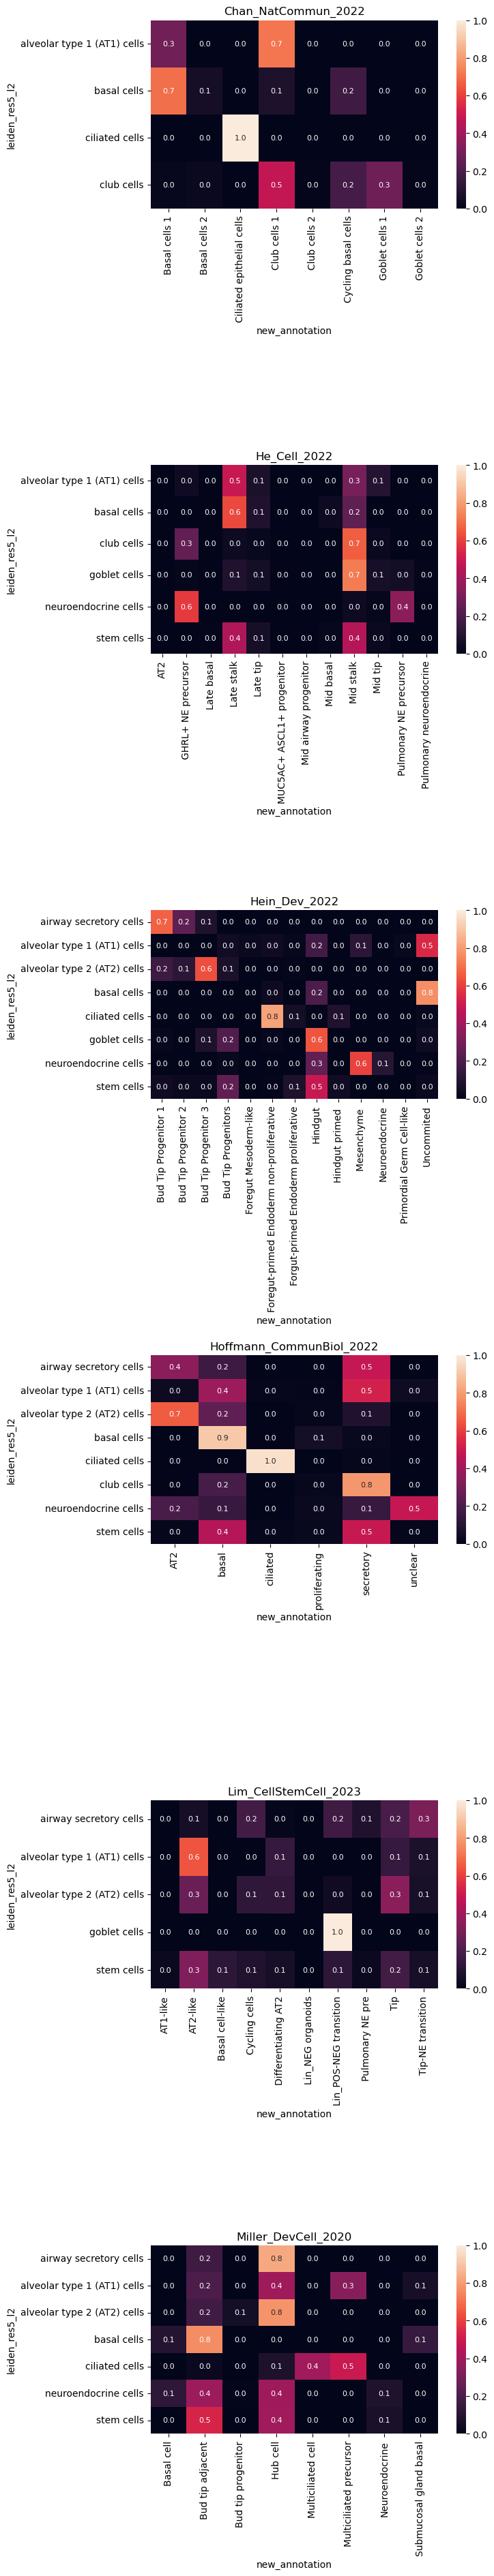

In [17]:
plot_all_mat(cellpect_res, output = "Output_sep_w_perc.pdf", annot = True)

In [18]:
# level 2 
def get_celltype_mat2(adata, return_all=False):

    if return_all: 
        
        # prepare plot 
        celltype_pair = adata.obs[adata.obs.publication.isin(has_annot_pub)][['level_2','leiden_res5_l2','new_annotation']].copy()

        # filter for epitheal cells in Quan 
        celltype_pair.leiden_res5_l2 = celltype_pair.leiden_res5_l2.astype('str')
        celltype_pair.new_amnotation = celltype_pair.new_annotation.astype('str')
        
        celltype_num = celltype_pair.groupby(['level_2','new_annotation']).count().reset_index()
        celltype_num = celltype_num.set_index('level_2')
        celltype_num = celltype_num.pivot(columns='new_annotation',values='leiden_res5_l2')
        
        celltype_num = celltype_num.loc[:,celltype_num.columns!='nan']
        
        celltype_num = celltype_num.loc[celltype_num.sum(1) > 5]
        celltype_pect = celltype_num.loc[:,celltype_num.sum(0) > 5]
        
        # celltype_pect = celltype_pect.loc[celltype_pect.sum(1) > celltype_pect.sum().sum()*0.001]
        
        celltype_pect = celltype_pect.div(celltype_pect.sum(1), axis=0)
        # celltype_pect = celltype_pect.loc[:,celltype_pect.sum(0)>0.001]
        
        celltype_pect = celltype_pect.fillna(0)
    
        return celltype_num, celltype_pect

    
    else:
        res_names = []
        cellnum_res = ()
        cellpect_res = ()

        for i in has_annot_pub:

            celltype_pair = adata.obs[adata.obs.publication==i][['level_2','leiden_res5_l2','new_annotation']].copy()

           # filter for epitheal cells in Quan 
            celltype_pair.leiden_res5_l2 = celltype_pair.leiden_res5_l2.astype('str')
            celltype_pair.new_annotation = celltype_pair.new_annotation.astype('str')

            celltype_num = celltype_pair.groupby(['level_2','new_annotation']).count().reset_index()
            celltype_num = celltype_num.set_index('level_2')
            celltype_num = celltype_num.pivot(columns='new_annotation',values='leiden_res5_l2')

            celltype_num = celltype_num.loc[:,celltype_num.columns!='nan']

            celltype_num = celltype_num.loc[celltype_num.sum(1) > 5]
            celltype_pect = celltype_num.loc[:,celltype_num.sum(0) > 5]
       
            celltype_pect = celltype_pect.loc[celltype_pect.sum(1) > celltype_pect.sum().sum()*0.001]

            celltype_pect = celltype_pect.div(celltype_pect.sum(1), axis=0)
            celltype_pect = celltype_pect.loc[:,celltype_pect.sum(0)>0.001]

            celltype_pect = celltype_pect.fillna(0)

            res_names.append(i)
            cellnum_res = (*cellnum_res, (celltype_num))
            cellpect_res = (*cellpect_res, (celltype_pect))
        return res_names, cellnum_res, cellpect_res


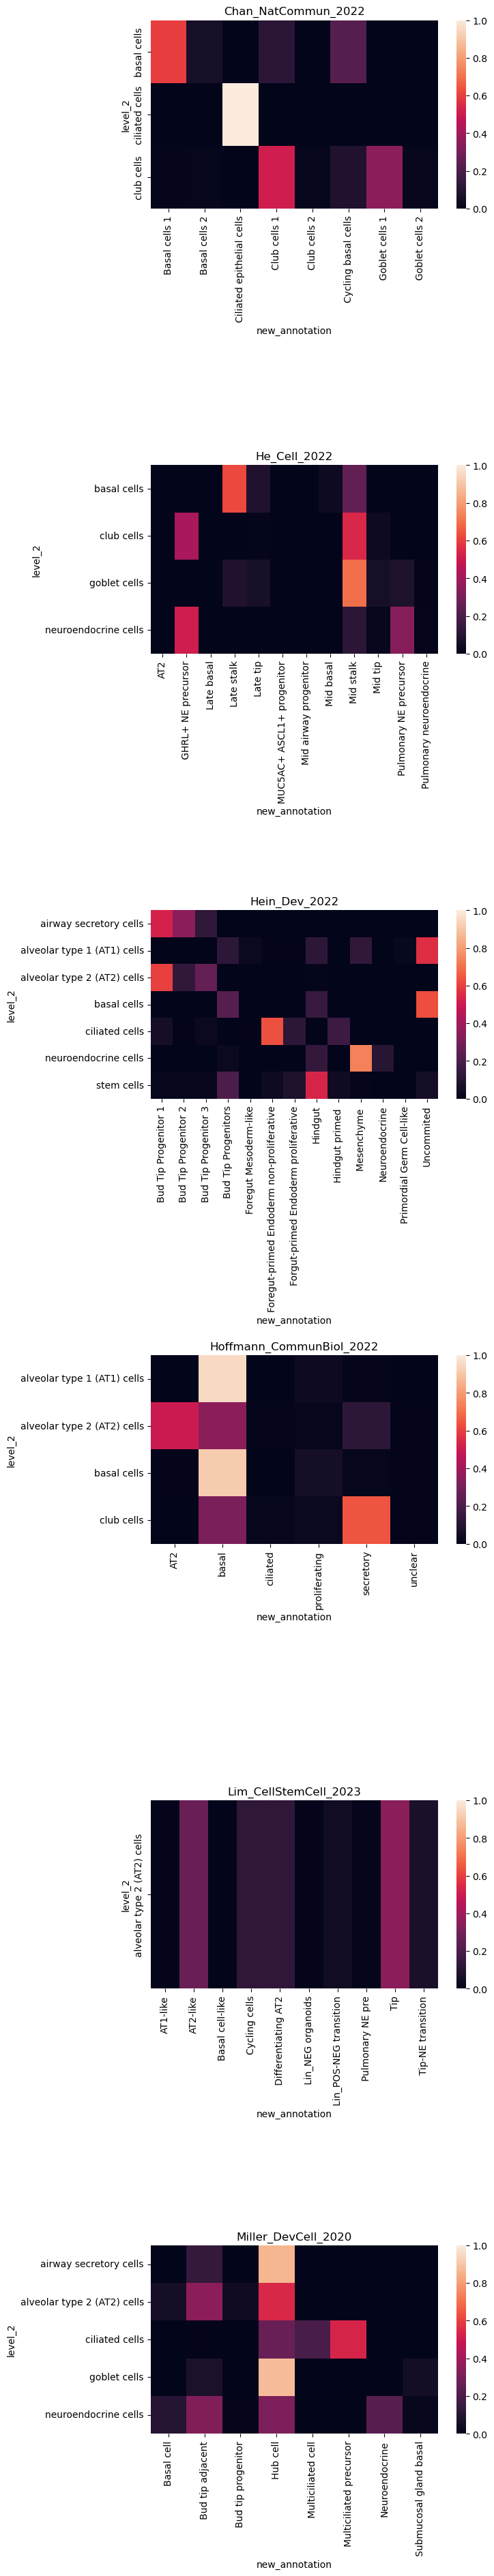

In [19]:
res_names, cellnum_res, cellpect_res = get_celltype_mat2(adata)
celltype_num, celltype_pect = get_celltype_mat2(adata, return_all=True)

plot_all_mat(cellpect_res, output = "Output_sep_wo_perc.pdf")

<Axes: title={'center': 'new_annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

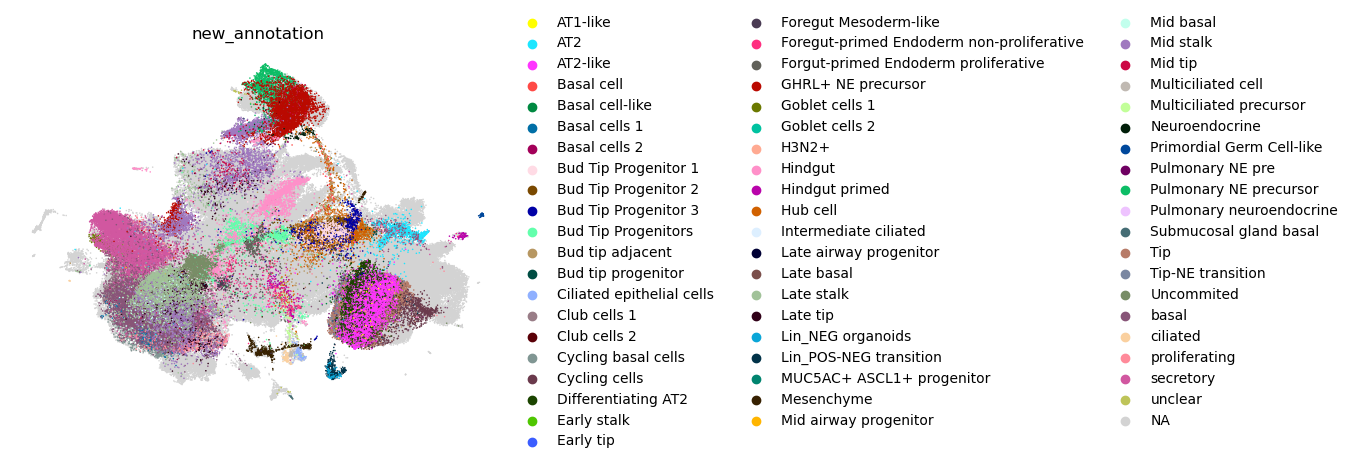

In [20]:
sc.pl.umap(adata, color=['new_annotation'], show=False,
           frameon=False, size=5, ncols=1)

In [21]:
# in Quan: simplification of names; new column with names 
ct2simple = {
    "Club cells 2": "Club cell (summarized)",
    "Club cells 1": "Club cell (summarized)", 
    "Goblet cells 1": "Goblet cell (summarized)",
    "Basal cells 2": "Basal cell (summarized)", 
    "Basal cells 1": "Basal cell (summarized)", 
    "Cycling basal cells": "Basal cell (summarized)",
    "Ciliated epithelial cells": "Ciliated cell (summarized)", 
    "Goblet cells 2": "Goblet cell (summarized)", 
    "secretory": "secretory",
    "basal": "Basal cell (summarized)",  
    "ciliated": "Ciliated cell (summarized)",  
    "AT2": "AT2 (summarized)",  
    "proliferating": "proliferating",  
    "unclear": "unclear",  
    "H3N2+": "H3N2+",  
    "Hub cell": "Hub cell",  
    "Bud tip adjacent": "Bud tip adjacent",  
    "Multiciliated precursor": "Ciliated cell (pre) (summarized)",  
    "Neuroendocrine": "Neuroendocrine cell (summarized)",  
    "Bud tip progenitor": "Tip (summarized)",  
    "Basal cell": "Basal cell (summarized)",  
    "Multiciliated cell": "Ciliated cell (pre) (summarized)",  
    "Submucosal gland basal": "Submucosal gland basal",  
    "Intermediate ciliated": "Ciliated cell (summarized)", 
    "Cycling cells": "Cycling cell",  
    "Tip": "Tip (summarized)", 
    "Tip-NE transition": "Tip-NE transition",  
    "Lin_POS-NEG transition": "Lin_POS-NEG transition", 
    "Pulmonary NE pre": "Neuroendocrine cell (pre) (summarized)", 
    "Basal cell-like": "Basal cell (summarized)", 
    "AT2-like": "AT2 (summarized)",  
    "Differentiating AT2": "AT2 (summarized)",
    "AT1-like": "AT1 (summarized)", 
    "Lin_NEG organoids": "Lin_NEG organoids",  
    "Pulmonary NE precursor": "Neuroendocrine cell (pre) (summarized)",  
    "Mid stalk": "Mid stalk",  
    "Pulmonary neuroendocrine": "Neuroendocrine cell (summarized)",  
    "Late tip": "Late tip",  
    "Mid airway progenitor": "Mid airway progenitor",  
    "Mid tip": "Mid tip",  
    "MUC5AC+ ASCL1+ progenitor": "MUC5AC+ ASCL1+ progenitor", 
    "Late stalk": "Late stalk", 
    "GHRL+ NE precursor": "Neuroendocrine cell (pre) (summarized)", 
    "Early tip": "Early tip",  
    "Late airway progenitor": "Late airway progenitor",  
    "Mid basal": "Basal cell (summarized)",
    "Late basal": "Basal cell (summarized)", 
    "Early stalk": "Early stalk", 
    "Uncommited": "Uncommited", 
    "Bud Tip Progenitors": "Bud Tip Progenitor (summarized)",  
    "Hindgut": "Hindgut (summarized)", 
    "Mesenchyme ": "Mesenchyme",  
    "Bud Tip Progenitor 2": "Bud Tip Progenitor (summarized)",  
    "Bud Tip Progenitor 1": "Bud Tip Progenitor (summarized)",  
    "Bud Tip Progenitor 3": "Bud Tip Progenitor (summarized)",  
    "Forgut-primed Endoderm proliferative": "Foregut-primed Endoderm (summarized)",  
    "Foregut-primed Endoderm non-proliferative": "Foregut-primed Endoderm (summarized)",  
    "Hindgut primed ": "Hindgut (summarized)",  
    "Primordial Germ Cell-like": "Primordial Germ Cell-like",  
    "Foregut Mesoderm-like": "Foregut Mesoderm-like"
}

adata.obs['new_annotation']=adata.obs.new_annotation.map(ct2simple)

res_names, cellnum_res, cellpect_res = get_celltype_mat(adata)
celltype_num, celltype_pect = get_celltype_mat(adata, return_all=True)

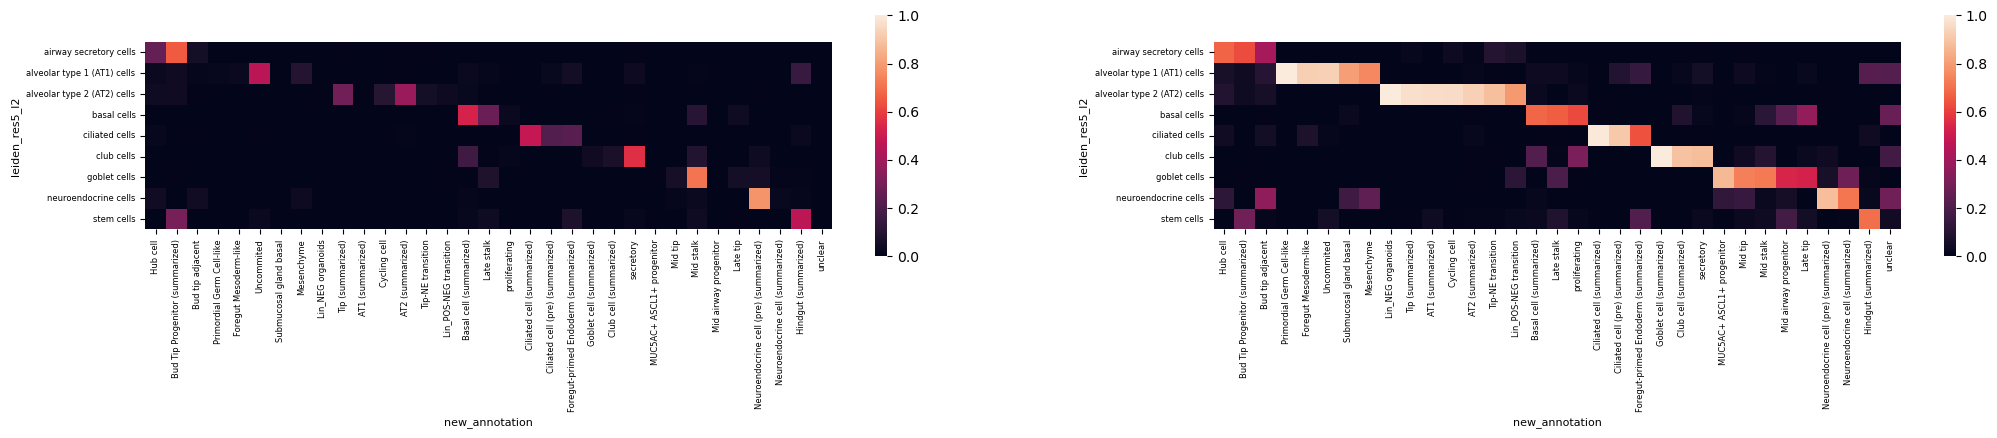

In [32]:
# Define the order of labels
label_order = [
    'Hub cell','Bud Tip Progenitor (summarized)', 'Bud tip adjacent',  'Primordial Germ Cell-like', 
    'Foregut Mesoderm-like', 'Uncommited',  'Submucosal gland basal','Mesenchyme',  'Lin_NEG organoids', 'Tip (summarized)','AT1 (summarized)', 
    'Cycling cell', 'AT2 (summarized)', 'Tip-NE transition',
    'Lin_POS-NEG transition', 'Basal cell (summarized)', 
    'Late stalk', 'proliferating', 'Ciliated cell (summarized)', 
    'Ciliated cell (pre) (summarized)', 'Foregut-primed Endoderm (summarized)', 'Goblet cell (summarized)', 
    'Club cell (summarized)', 'secretory', 'MUC5AC+ ASCL1+ progenitor',
    'Mid tip', 'Mid stalk',  'Mid airway progenitor','Late tip', 
    'Neuroendocrine cell (pre) (summarized)', 
    'Neuroendocrine cell (summarized)', 'Hindgut (summarized)'
]

# Ensure labels not in label_order are added at the end
additional_labels = [col for col in celltype_pect.columns if col not in label_order]
label_order.extend(additional_labels)

# Reorder columns and rows based on label_order
celltype_pect = celltype_pect.reindex(columns=label_order, fill_value=0)
celltype_pect_normalized = celltype_pect.div(celltype_pect.sum(0), axis=1).reindex(columns=label_order, fill_value=0)

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(20, 3))
fig.tight_layout(w_pad=12)

sns.heatmap(celltype_pect, square=True, vmin=0, vmax=1, ax=axs[0] #, annot=True, fmt=".2f", annot_kws={"size": 7}
           )
sns.heatmap(celltype_pect_normalized, square=True, vmin=0, vmax=1, ax=axs[1] #, annot=True, fmt=".2f", annot_kws={"size": 7}
           )

for ax in axs:
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)  # Font size for x-axis label
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Font size for y-axis label
    ax.tick_params(axis='both', which='major', labelsize=6)  # Font size for tick labels

# Save the figure as a PDF
with PdfPages("output_all.pdf") as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.show()


In [24]:
cell_type_colors = {
    "biliarysystem": "#A73030",
    "intestine": "#91D1C2",
    "liver": "#8F7700",
    "lung": "#F39B7F",
    "pancreas": "#DC0000",
    "prostate": "#4A6990",
    "salivarygland": "#3B3B3B",
    "stomach": "#B09C85",
    "thyroid": "#7E6148",
    "epithelial": "#0073C2",
    "mesenchymal": "#A3E3AF",
    "stromal": "#A3E3AF",
    "neural": "#111111",
    "endothelial": "#CD534C",
    "immune": "#C251A1",
    "stem cells": "#777777",
    "enterocytes": "#225805",
    "stromal 2 (NPY)": "#E4B974",
    "colonocytes": "#FFB300",
    "goblet cells": "#8E3101",
    "cycling stromal cells": "#47EDD1",
    "Interstitial cells of Cajal (ICC)": "#F47A92",
    "smooth muscle cells (SMC)": "#2D62A3",
    "mesoderm 1 (HAND1)": "#9106EB",
    "pericytes": "#573794",
    "Microfold cells": "#F82745",
    "mesoderm 2 (ZEB2)": "#6435E0",
    "schwann cell": "#027FFE",
    "basal cells": "#E68A54",
    "ciliated cells": "#1C15BC",
    "enteroendocrine cells": "#F7DC6F",
    "mesothelial cells": "#7DCEA0",
    "neuron": "#111111",
    "tuft cells": "#9E018A",
    "cycling endothelial cells": "#BDFD0B",
    "stromal 1 (ADAMDEC1)": "#B22760",
    "lymphatic endothelium": "#2BF49F",
    "paneth cells": "#CB9348",
    "biliary cells": "#43A047",
    "mLTo cells": "#46ADAF",
    "BEST4+ epithelial": "#870F0F",
    "club cells": "#795548",
    "alveolar type 1 (AT1) cells": "#85C1E9",
    "stellate cells": "#EAD9D5",
    "thyrocytes": "#CDDC39",
    "pit cells": "#8D6E63",
    "ductal cells": "#6300B5",
    "pancreatic cells": "#012824",
    "neck cells": "#A347FB",
    "neuroendocrine cells": "#CE35E6",
    "cardiovascular cells": "#FE52CF",
    "alveolar type 2 (AT2) cells": "#F8E347",
    "chief cells": "#6C6F15",
    "hepatocytes": "#7788CD",
    "beta cells": "#0DC290",
    "acinar cells": "#3CAA0A",
    "kupffer cells": "#08F8EB",
    "stromal 3 (C7)": "#5DEB2E",
    "stromal 4 (MMP1)": "#D6A5FA",
    "arterial": "#AB1EBA",
    "capillary": "#054DDC",
    "mLN stromal": "#854F49",
    "portal endothelial": "#3A0E43",
    "central endothelial": "#37D160",
    "airway secretory cells": "#A8BADE",
    "epsilon cells": "#C76CDE",
    "alpha cells": "#D7FDFD",
    "delta cells": "#8BE46E",
    "luminal cells": "#E68FC6",
    "quiescent cells": "#6EA3FA",
    "fibroblast": "#3E35B7",
    "mature enterocytes": "#225805",
    "mature colonocytes": "#537F88",
    "myofibroblasts": "#F2D71E",
    "enterocyte precursors": "#12401F",
    "MUC2- goblet cells": "#5536D5",
    "immature pericytes": "#D2B993",
    "M/X cells": "#DED8CE",
    "RGS5 pericytes": "#CC4285",
    "younger goblet cells": "#C3EACA",
    "portal hepatocytes": "#E42859",
    "central hepatocytes": "#86564A",
    "enterochromaffin cells": "#55F97A",
    "colonocyte precursors": "#4AA08F",
    "D cells": "#9006E9",
    "N cells": "#1354E2",
    "L cells": "#4C51A5",
    "older goblet cells": "#D2BB71",
    "BEST2 goblet cells": "#D257D7",
    "K cells": "#D93329",
    "angiogenic pericytes": "#24BB35",
    "SMC 1 (PLPP2)": "#C9A580",
    "PRG4 pericytes": "#6E9979",
    "contractile pericytes": "#64652F",
    "I cells": "#946262",
    "Enterocyte": "#225805",
    "Enteroendocrine": "#F7DC6F",
    "Enterocyte_precursor": "#1F77B4",
    "Goblet": "#8E3101",
    "M_cell": "#F82745",
    "Stem_cell": "#777777",
    "Tuft": "#9E018A",
    "colon": "#465982",
    "duodenal": "#90D8AF",
    "ileum": "#F8871A",
    "IPS": "#4DBBD5",
    "tIPS": "#00A087",
    "FSC": "#8491B4",
    "FSC early": "#003C67",
    "FSC late": "#3C5488",
    "ASC": "#E64B35",
    "PSC": "#4DBBD5",
    "tPSC": "#00A087",
    "spleen": "#7AA6DC",
    "thymus": "#EFC000",
    "Small_Intestine": "#91D1C2",
    "Intestine": "#91D1C2",
    "Large_Intestine": "#37AB6C",
    "Liver": "#8F7700",
    "Lung": "#F39B7F",
    "Pancreas": "#DC0000",
    "Prostate": "#4A6990",
    "Salivary_Gland": "#3B3B3B",
    "Thymus": "#7E6148",
    "Trachea": "#F39B7F",
    "Esophagus": "#43A047",
    "esophagus": "#43A047",
    "Stomach": "#B09C85",
    "endothelial cell of hepatic sinusoid": "#15889C",
    "hepatocyte": "#7788CD",
    "intrahepatic cholangiocyte": "#A2C8EB",
    "acinar cell of salivary gland": "#CC7DA5",
    "pericyte cell": "#AE4DDD",
    "endothelial cell of lymphatic vessel": "#83D397",
    "adventitial cell": "#388CAF",
    "endothelial cell": "#C93476",
    "duct epithelial cell": "#2B7BC5",
    "basal cell": "#E68A54",
    "myoepithelial cell": "#A466A4",
    "pancreatic acinar cell": "#3CAA0A",
    "pancreatic stellate cell": "#9A384B",
    "pancreatic ductal cell": "#5469C9",
    "pancreatic beta cell": "#0DC290",
    "basal cell of prostate epithelium": "#6C8F44",
    "epithelial cell": "#73CFC0",
    "hillock-club cell of prostate epithelium": "#89DB96",
    "luminal cell of prostate epithelium": "#C02DDC",
    "smooth muscle cell": "#C732E5",
    "stromal cell": "#AA2E96",
    "salivary gland cell": "#486EF5",
    "ionocyte": "#A2E2AE",
    "enterocyte of epithelium of large intestine": "#61E190",
    "large intestine goblet cell": "#BAA8E4",
    "paneth cell of epithelium of large intestine": "#FF7300",
    "transit amplifying cell of large intestine": "#FD4C7A",
    "gut endothelial cell": "#B423DF",
    "intestinal crypt stem cell of large intestine": "#777777",
    "intestinal enteroendocrine cell": "#8F6DAD",
    "intestinal tuft cell": "#9D9B9B",
    "type ii pneumocyte": "#FFA900",
    "bronchial vessel endothelial cell": "#886573",
    "respiratory mucous cell": "#C05E3F",
    "club cell of prostate epithelium": "#3C5939",
    "hillock cell of prostate epithelium": "#844F4A",
    "enterocyte of epithelium of small intestine": "#225805",
    "transit amplifying cell of small intestine": "#F3D26D",
    "small intestine goblet cell": "#6C9952",
    "paneth cell of epithelium of small intestine": "#196493",
    "intestinal crypt stem cell of small intestine": "#614C61",
    "immature enterocyte": "#CF5A3E",
    "intestinal crypt stem cell": "#600ABB",
    "mature enterocyte": "#C21DF3",
    "goblet cell": "#8E3101",
    "endothelial cell of artery": "#D2F677",
    "lung ciliated cell": "#994841",
    "respiratory goblet cell": "#846437",
    "serous cell of epithelium of bronchus": "#686EB1",
    "capillary endothelial cell": "#0C8CA9",
    "capillary aerocyte": "#40A509",
    "type i pneumocyte": "#284415",
    "vein endothelial cell": "#5A6ECE",
    "alveolar fibroblast": "#66153A",
    "bronchial smooth muscle cell": "#FA6767",
    "club cell": "#795548",
    "lung microvascular endothelial cell": "#509343",
    "vascular associated smooth muscle cell": "#8C78A7",
    "myofibroblast cell": "#C76BDA",
    "mesothelial cell": "#7DCEA0",
    "pulmonary ionocyte": "#34A673",
    "pancreatic pp cell": "#BAEB13",
    "pancreatic alpha cell": "#D7FDFD",
    "pancreatic delta cell": "#8BE46E",
    "duodenum glandular cell": "#5AB8AF",
    "endothelial cell of vascular tree": "#BB55E0",
    "intestinal epithelial cell": "#6BC83A",
    "myeloid cell": "#B46268",
    "innate lymphoid cell": "#59D885",
    "glial cell": "#28CE60",
    "chromaffin cell": "#6CC3AF",
    "erythroblast": "#73CD31",
    "hepatoblast": "#BD54A1",
    "hepatic stellate cell": "#0FC08E",
    "hematopoietic stem cell": "#6E8E7F",
    "megakaryocyte": "#8A43E9",
    "epithelial cell of lower respiratory tract": "#4C6E9A",
    "ciliated epithelial cell": "#62DA91",
    "neuroendocrine cell": "#CE35E6",
    "squamous epithelial cell": "#D0C03C",
    "visceromotor neuron": "#D27258",
    "native cell": "#70D37E",
    "acinar cell": "#3CAA0A",
    "endocrine cell": "#67DCD5",
    "enteric neuron": "#B041E3",
    "brush cell": "#5B20C8",
    "Mesenchyme subtype 2": "#E4B974",
    "Mesenchyme subtype 3": "#D6A5FA",
    "Mesenchyme subtype 1": "#B22760",
    "Mesenchyme subtype 4": "#47EDD1",
    "Intestinal epithelium": "#ED496F",
    "Proliferative mesenchyme": "#A3E3AF",
    "Mesenchyme subtype 5": "#854F49",
    "Macrophage/monocyte 2": "#B09C85",
    "T cell/NK cell 2": "#EB1388",
    "Endothelial": "#CD534C",
    "Basal like": "#E68A54",
    "Distal lung epithelium": "#85C1E9",
    "Erythroblast": "#73CD31",
    "PNS neuron": "#868686",
    "PNS glia": "#AFB9D1",
    "Pericyte": "#573794",
    "Chondrocyte": "#08F8EB",
    "Gastrointestinal epithelium": "#0073C2",
    "Ciliated": "#1C15BC",
    "B cell": "#C251A1",
    "Macrophage/monocyte 1": "#7E6148",
    "MUC2+ goblet": "#8E3101",
    "T cell/NK cell 1": "#FE52CF",
    "Enteroendocrine": "#F7DC6F",
    "Undefined": "gray",
    "Hepatocyte": "#7788CD",
    "Mesothelial cell": "#7DCEA0"
}

<Axes: title={'center': 'new_annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

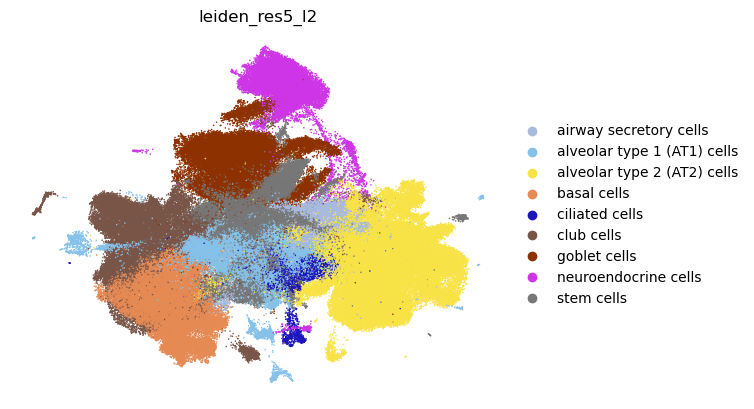

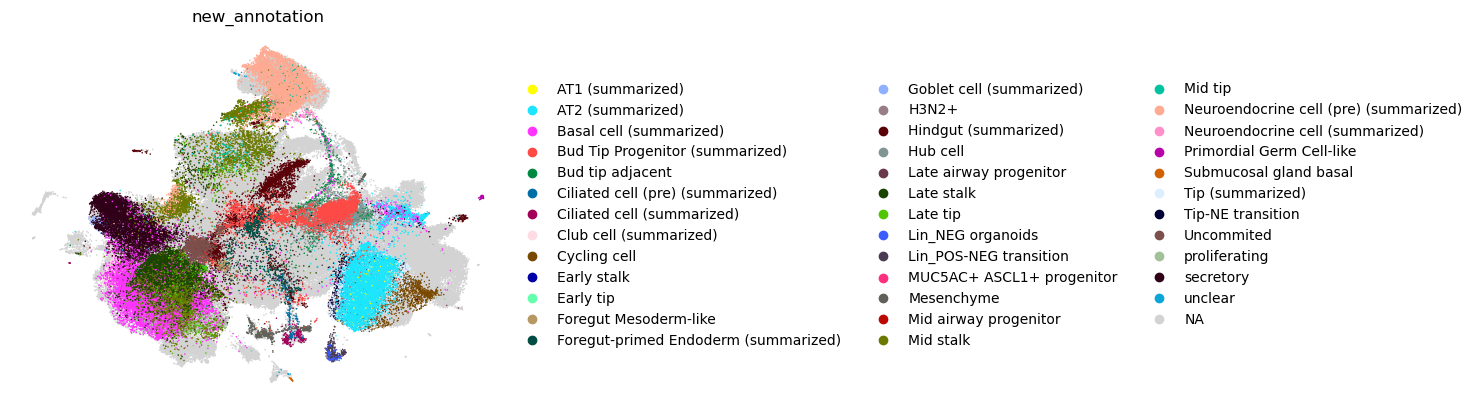

In [25]:
sc.pl.umap(adata, color=['leiden_res5_l2'], palette = cell_type_colors, show=False,
           frameon=False, size=5, ncols=1)
sc.pl.umap(adata, color=['new_annotation'], show=False,
           frameon=False, size=5, ncols=1)